In [1]:
import tensorflow
import ujson as json
import requests
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
with open('/Users/lukasdraschkowitz/Downloads/convertcsv2-2.json', 'r', encoding='utf-8') as data_file:
    data = json.loads(data_file.read())

In [3]:
df = pd.DataFrame(data)

In [4]:
import numpy as np
df['pledged'] = pd.to_numeric(df['pledged'],errors='coerce')
df['goal'] = pd.to_numeric(df['goal'],errors='coerce')
df['simscore'] = pd.to_numeric(df['simscore'].astype(str).str[:-25],errors='coerce')#.astype(np.int64)
df['popscore'] = pd.to_numeric(df['popscore'].astype(str).str[:-25],errors='coerce')#.astype(np.int64)
df['totFav'] = pd.to_numeric(df['totFav'].astype(str).str[:-10],errors='coerce')#.astype(np.int64)
df['totRetweet'] = pd.to_numeric(df['totRetweet'].astype(str).str[:-10],errors='coerce')#.astype(np.int64)
df['twitterstat'] = pd.to_numeric(df['twitterstat'].astype(str).str[:-30],errors='coerce')#.astype(np.int64)
#df['simscore'] = pd.to_numeric(df['simscore'],errors='coerce')
#df['popscore'] = pd.to_numeric(df['popscore'],errors='coerce')
df['label'] = np.where(df['goal'] < df['pledged'] , 1, np.where(df['goal'] >= df['pledged'], 0, 0))

#label = "final_status"
y = df['label'].values

In [5]:
df2 = df[['avgSent','avgText','goal','newsstat','popscore','simscore','totFav','totRetweet','twitterstat']].apply(pd.to_numeric, errors='coerce')
df2 = df2.fillna(0)
X = df2.values

In [17]:
#splitting the dataset into training and testing dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [9]:
df2.head(5)

avgSent     avgText          goal  newsstat  popscore  simscore  \
0    1.582751  132.582751  6.600000e+02      60.0  7.824632  9.257716   
1  132.525822    0.000000  1.534651e+10     252.0  7.351506  0.000000   
2    0.000000   50.000000  0.000000e+00       0.0  0.000000  0.000000   
3    1.583138  132.543326  7.000000e+02      40.0  5.179289  7.549596   
4    1.583138  132.543326  3.250000e+02      60.0  7.409940  7.419111   

    totFav  totRetweet  twitterstat  
0  0.00000     0.00000          0.0  
1  0.00000     1.58216          0.0  
2  1.58216   132.52582          0.0  
3  0.00000     0.00000          0.0  
4  0.00000     0.00000          0.0

In [ ]:
df3 = df[['label','pledged','title','popscore','simscore']]
df3.sort_values(by=['simscore']).tail(50)

In [10]:
print(X_train.shape, X_test.shape)

(107, 9) (12, 9)


In [7]:
#feature scaling

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [229]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [233]:
import warnings
warnings.filterwarnings('ignore')
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers

#Initaializing the ANN
classifier = Sequential()

#Adding the input layer and the first hidden layer with dropout
classifier.add(Dense(activation="relu", kernel_initializer="uniform", input_dim=X_train.shape[1], units=X_train.shape[1]//2))
classifier.add(Dropout(rate = 0.55))

#Adding the second hidden layer
classifier.add(Dense(activation="relu", kernel_initializer="uniform", units=X_train.shape[1]//2))
classifier.add(Dropout(rate = 0.05))

#Adding the third hidden layer
#classifier.add(Dense(activation="relu", kernel_initializer="uniform", units=6))
#classifier.add(Dropout(rate = 0.1))

#Adding the output layer
classifier.add(Dense(activation="sigmoid", kernel_initializer="uniform", units=1))

#Compiling the ANN
#sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
#classifier.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])
classifier.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])

#mean_squared_error

In [241]:
#Fitting the ANN to training set
classifier.fit(X_train, y_train, batch_size=50, epochs=20)

Epoch 1/20
107/107 [==============================] - 0s 1ms/step - loss: 1.2346 - acc: 0.7383
Epoch 2/20
107/107 [==============================] - 0s 183us/step - loss: 1.3100 - acc: 0.7477
Epoch 3/20
107/107 [==============================] - 0s 143us/step - loss: 0.9347 - acc: 0.7944
Epoch 4/20
107/107 [==============================] - 0s 153us/step - loss: 0.8795 - acc: 0.8131
Epoch 5/20
107/107 [==============================] - 0s 119us/step - loss: 0.9994 - acc: 0.7290
Epoch 6/20
107/107 [==============================] - 0s 123us/step - loss: 1.0965 - acc: 0.7664
Epoch 7/20
107/107 [==============================] - 0s 129us/step - loss: 0.7409 - acc: 0.8224
Epoch 8/20
107/107 [==============================] - 0s 181us/step - loss: 0.5672 - acc: 0.8692
Epoch 9/20
107/107 [==============================] - 0s 140us/step - loss: 0.7098 - acc: 0.8785
Epoch 10/20
107/107 [==============================] - 0s 138us/step - loss: 0.6707 - acc: 0.8785
Epoch 11/20
107/107 [==========

In [242]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)
#Making the confusion matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['0','1']))

             precision    recall  f1-score   support

          0       0.75      1.00      0.86         9
          1       0.00      0.00      0.00         3

avg / total       0.56      0.75      0.64        12



In [ ]:
from matplotlib import pyplot as plt

In [248]:
XX = pd.DataFrame(X_test)
XX['pscore'] = classifier.predict(X_test)

In [267]:
t = classifier.predict(X_test[0:1,:])

In [268]:
t

array([[ 0.99360389]], dtype=float32)

In [269]:
X_test[0:1,:]

array([[ 0.62017367, -0.24253563, -0.24253563,  0.        ,  0.        ,
        -0.24253563,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.24253563,  0.        ,  0.        ,
        -0.24253563,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.24253563,
         0.        ,  0.        , -0.4472136 ,  0.        , -0.24253563,
         0.        , -0.24253563, -0.24253563,  0.        ,  0.79772404,
        -0.39129953,  0.72942699, -0.2070185 ,  0.94819965,  1.04949061,
         1.04769629, -0.87405565,  0.07500393,  1.04731971, -0.6681531 ,
         1.11803399]])

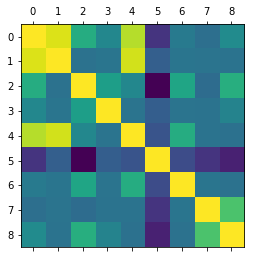

In [129]:
plt.matshow(df2.corr())

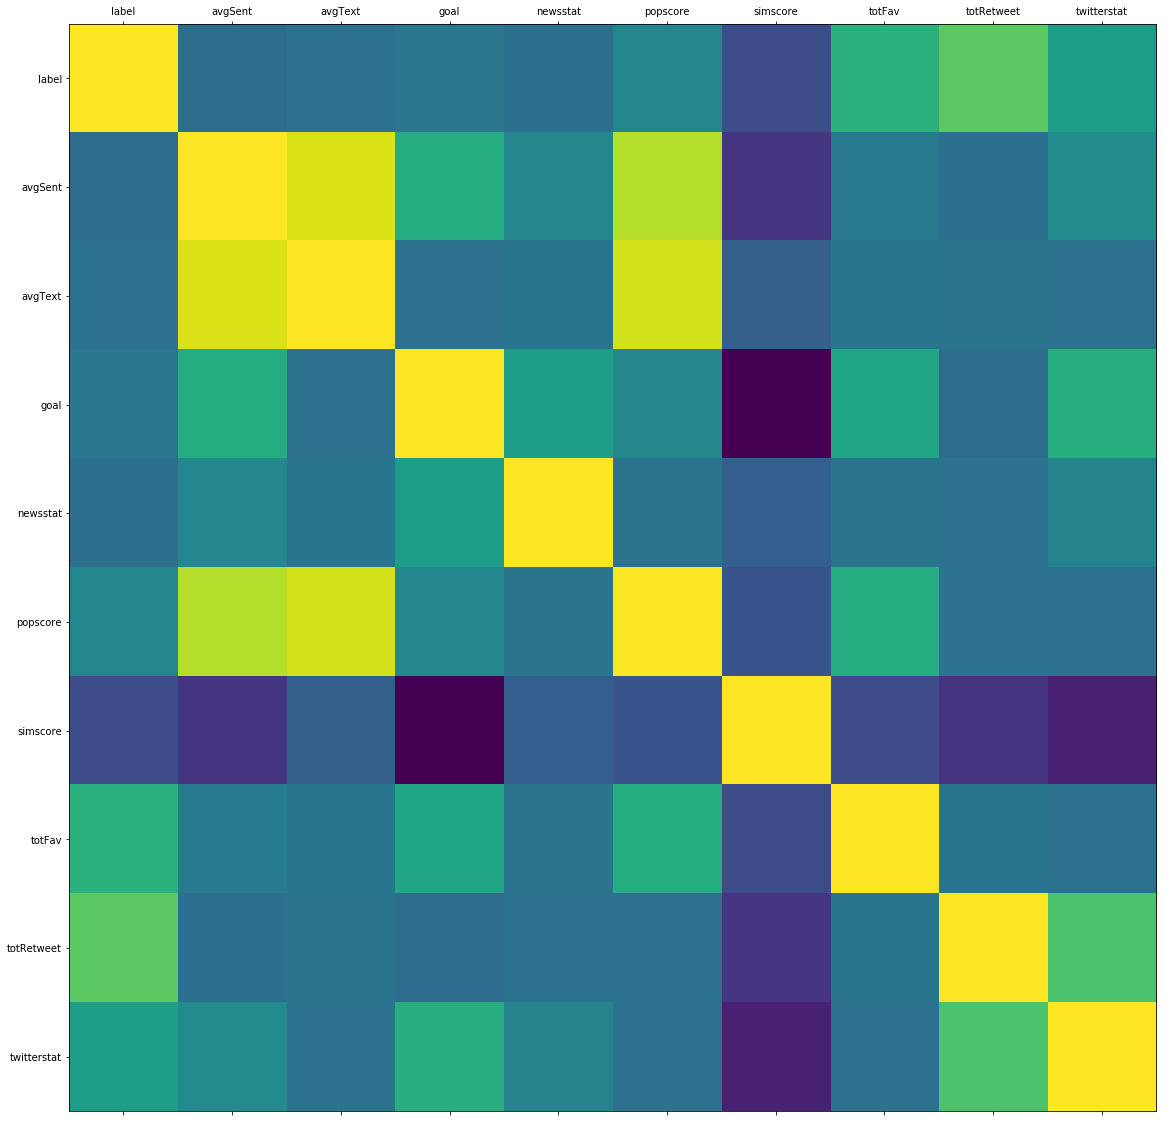

In [130]:
    df3 = df[['label','avgSent','avgText','goal','newsstat','popscore','simscore','totFav','totRetweet','twitterstat']].apply(pd.to_numeric, errors='coerce')
df3 = df3.fillna(0)
    
    corr = df3.corr()
    size = 20
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [1]:
corr

NameError: name 'corr' is not defined

In [18]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.33%


In [19]:
y_pred = model.predict(X_test)
#y_pred = (y_pred > 0.5)
predictions = [round(value) for value in y_pred]
#Making the confusion matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['0','1']))

             precision    recall  f1-score   support

          0       0.89      0.89      0.89         9
          1       0.67      0.67      0.67         3

avg / total       0.83      0.83      0.83        12



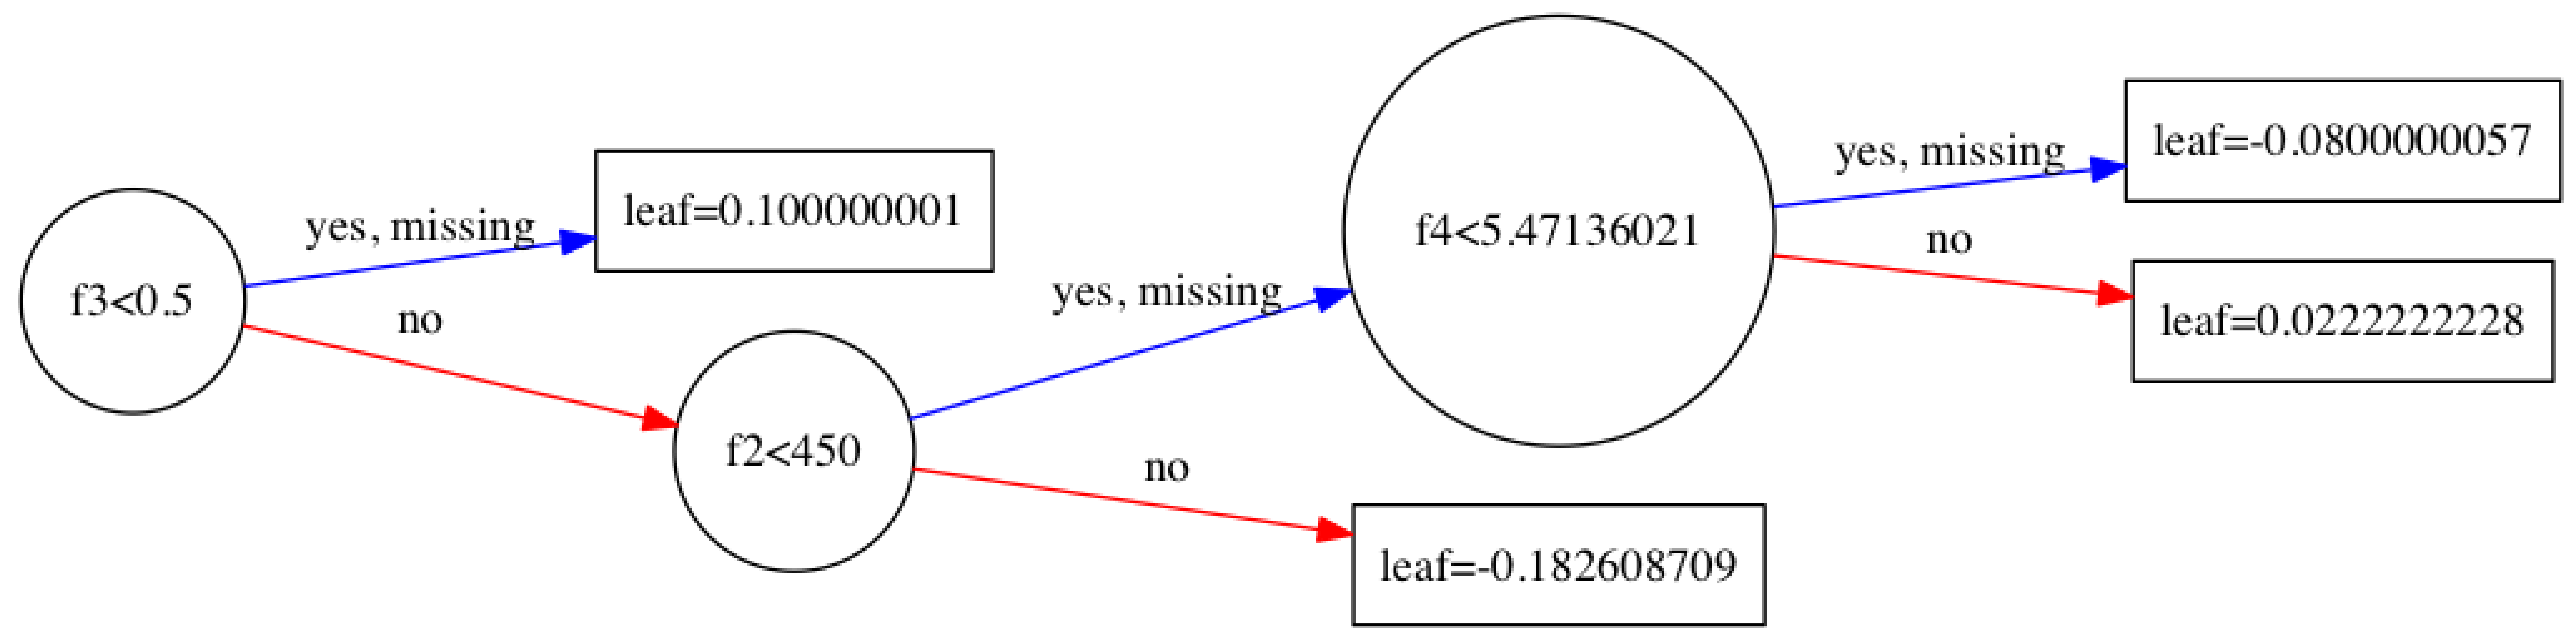

In [33]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams



# plot single tree
#plot_tree(model)
plot_tree(model, num_trees=0, rankdir='LR')

#plot_tree(feature_names = ['avgSent','avgText','goal','newsstat','popscore','simscore','totFav','totRetweet','twitterstat'], model =model, num_trees=0, rankdir='LR') 
##set up the parameters
rcParams['figure.figsize'] = 800,50
plt.show()

In [42]:
df2.describe()

avgSent       avgText          goal     newsstat      popscore  \
count  1049.000000  1.049000e+03  1.049000e+03  1049.000000  1.049000e+03   
mean      2.843021  1.547342e+07  3.027642e+08    16.436540  2.392304e+07   
std      34.483238  5.011567e+08  2.120011e+09   308.759585  5.359889e+08   
min       0.000000  0.000000e+00  0.000000e+00     0.000000  0.000000e+00   
25%       0.000000  0.000000e+00  5.000000e+02     0.000000  0.000000e+00   
50%       0.000000  0.000000e+00  2.000000e+03     0.000000  0.000000e+00   
75%       0.000000  0.000000e+00  6.530000e+03     0.000000  0.000000e+00   
max    1010.000000  1.623160e+10  1.537964e+10  9901.000000  1.535782e+10   

           simscore       totFav   totRetweet  twitterstat  
count  1.049000e+03  1049.000000  1049.000000  1049.000000  
mean   5.004482e+07     0.319024     0.778873     1.183031  
std    7.527197e+08     6.073917    10.002816    12.511707  
min    0.000000e+00     0.000000     0.000000     0.000000  
25%    0.000000e+00     0.000000     0.000000     0.000000  
50%    0.000000e+00     0.000000     0.000000     0.000000  
75%    0.000000e+00     0.000000     0.000000     0.000000  
max    1.673052e+10   132.617169   132.634259   299.000000

In [107]:
df3 = (df2['simscore']).apply(pd.to_numeric)


In [108]:
df3[df3 >0]

0      9.257716
3      7.549596
4      7.419111
5      7.172674
6      7.242602
7      6.669729
9      6.052764
11     6.297343
12     6.820918
14     6.519110
16     6.962699
17     6.821103
18     6.509907
19     5.363323
20     5.752096
21     5.110361
22     5.395949
23     5.254433
24     5.731436
25     5.046139
26     5.268706
27     5.036939
28     5.051686
29     5.677499
30     5.827050
31     5.430953
32     5.793196
34     5.535080
35     5.794481
36     5.609379
         ...   
82     4.270051
83     4.217670
84     4.317231
85     4.232265
86     4.984180
87     4.298524
88     4.329574
89     4.787672
90     4.386595
93     4.688377
94     4.504311
95     4.516465
96     4.217986
98     4.233000
100    4.548037
101    4.452069
102    4.711660
103    3.329423
104    3.864147
105    3.880572
106    3.821773
107    3.264474
108    3.879052
109    3.812908
111    3.406409
112    3.748366
114    3.959686
116    3.725761
117    3.757042
118    1.733242
Name: simscore, Length: 

In [34]:
X_train

array([[  0.00000000e+00,   5.00000000e+01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.58215960e+00,   1.32525820e+02,   0.00000000e+00],
       [  1.58313817e+00,   1.32543326e+02,   9.00000000e+03,
          3.00000000e+01,   4.21066430e+00,   4.35173530e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.58275058e+00,   1.32582751e+02,   1.69500000e+03,
          3.00000000e+01,   4.03889910e+00,   1.73324184e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.58411215e+00,   1.32560748e+02,   2.00000000e+04,
          4.00000000e+01,   5.19531560e+00,   4.40138000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.58313817e+00,   1.32543326e+02,   1.20000000e+04,
          6.00000000e+01,   6.98936380e+00,   5.82705000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.58275058e+00,   1.32582751e+02,   5.00000000e+02,
   